In [1]:
from IPython.display import display, HTML
from ipywidgets import interact, widgets
%matplotlib notebook

import numpy as np
import cmath
import matplotlib.pyplot as plt
import os
import h5py

print(os.getpid())
%cd ../../

16327
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pylib.mix as mix
import pylib.qucf_read as qucf_r
import pylib.qucf_oracle as qucf_o
import pylib.qucf_matrix_D as qucf_m
import ASE as ase
import pylib.qsvt_angles as qsvt_a

for i in range(30):
    plt.close()

In [3]:
# ---------------------------------------------------------------
# --- Read data ---
# ---------------------------------------------------------------
mix.reload_module(ase)

print("\n--- Creating the object with data... ---")
data_ = ase.ASE_()

print("\n--- Reading matrices D from quantum simulations ---")
data_.read_D_matrices()

print("\n\n--- Reading matrices of the considered 1D kinetic problem --") 
data_.read_plasma_matrices()

print("--- Creating a template to extrapolate the matrix D for larger sizes ---") 
data_.create_D_template()


--- Creating the object with data... ---

--- Reading matrices D from quantum simulations ---

Reading the matrix from: flat_33_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/matrices-D/
date of the simulation:  06-06-2023 09:51:13
matrix name:  U_BE
N = 128

Reading the matrix from: flat_44_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/matrices-D/
date of the simulation:  06-06-2023 08:57:47
matrix name:  U_BE
N = 512

Reading the matrix from: flat_45_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/matrices-D/
date of the simulation:  06-23-2023 15:42:09
matrix name:  U_BE
N = 1024

Reading the matrix from: flat_54_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/matrices-D/
date of the simulation:  06-23-2023 15:48:52
matrix name:  U_BE
N = 1024


--- Reading matrices of the considered 1D kinetic problem --

Reading data from out_3_3_w1.2_Lx100_Lv4_flat.hdf5...
date of the simulation:  06-22-2023 15:48:52
N, nx, nv = 128, 3, 3
Done.

Reading data from out_4_4_w1.2_Lx10

In [19]:
# --------------------------------------------------------------------
# --- Choose a case (matrix size) with which you are going to work ---
# --------------------------------------------------------------------
data_.choose_a_case(nx = 4, nv = 4)

original matrix >>>
amax. value: 			4.000e+00
amin.(excl. zero) value: 	2.855e-04

norm of the matrix:  9.907124260405292

normalized matrix >>>
amax. value: 			3.552e-03
amin.(excl. zero) value: 	2.535e-07



In [20]:
# ------------------------------------------------------------------------------------------
# --- [OPTIONAL] Compare the reconstructed matrix D with the calculated one if available ---
# ------------------------------------------------------------------------------------------
data_.DF_work_.is_the_same_as(
    data_.get_original_D_matrix(), 
    data_.circ_.prec_
)

The matrices are the same


In [21]:
# -----------------------------------------------
# --- Computation of the oracle's angles ---
# -----------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_o)


print("N, Nx, Nv: {:d}, {:d}, {:d}".format(
    data_.BF_fixed_.get_N(), 
    1<<data_.nx_work_, 
    1<<data_.nv_work_
))
print()

# Split the matrix into diagonals:
grid_sections = qucf_o.create_grid_of_sections(
    data_.circ_, 
    data_.BF_fixed_
)

# -- Create sections of sets (sets = groups):
sys_gates_ = qucf_o.SystemGates__(
    data_.circ_, 
#     qucf_o.create_groups(data_.circ_, grid_sections)            # Option 1
    qucf_o.create_groups_neighbor(data_.circ_, grid_sections) # Option 2
)
print("--- Initial number of groups ---")
sys_gates_.count_groups()


# Recreate the matrix using the ORIGINAL groups
print("--- Reconstruction using original groups ---")
sys_gates_.reconstruct_matrix_using_GROUPS().is_the_same_as(
    data_.BF_fixed_, 
    prec = data_.circ_.prec_
)

# # Split groups (optional):
# sys_gates_.n_split_ = 1
# sys_gates_.split_groups()
# sys_gates_.split_groups()
# sys_gates_.split_groups()
# sys_gates_.split_groups()
# sys_gates_.split_groups()
# print("--- After the splitting ---")
# sys_gates_.count_groups()

# Sort groups:
sys_gates_.sort_groups()

# Extend the gates:
sys_gates_.set_rows_limit_for_non_extension(4)
sys_gates_.extend_sorted_groups(data_.BF_fixed_)

# merge groups:
sys_gates_.merge_groups()
print("\n--- After the merging ---")
sys_gates_.count_groups()

# preliminary correction (optional):
sys_gates_.correct_close_groups()

# add correcting groups:
sys_gates_.correct_groups(data_.BF_fixed_)
print("--- After adding the correcting groups ---")
sys_gates_.count_groups()

# Recreate the matrix using the CORRECTED groups
print("--- Reconstruction using corrected groups ---")
sys_gates_.reconstruct_matrix_using_GRID().is_the_same_as(
    data_.BF_fixed_, 
    prec = data_.circ_.prec_
)

# Construct the circuit:
print("\n--- Circuit construction ---")
print("N-nonzero-elements in the flat-elements-matrix: ", int(data_.BF_fixed_.get_Nnz()))
sys_gates_.construct_circuit_OH(
    data_.path_qc_, 
    data_.file_name_oracle_
)

N, Nx, Nv: 256, 16, 16

--- Initial number of groups ---
Number of groups: 128

--- Reconstruction using original groups ---
The matrices are the same

--- After the merging ---
Number of groups: 118

--- After adding the correcting groups ---
Number of groups: 340

--- Reconstruction using corrected groups ---
The matrices are the same

--- Circuit construction ---
N-nonzero-elements in the flat-elements-matrix:  784
N-gates: 486
N-gates (assuming Rc as a single gate): 246


/media/work/docs/codes/QuCF/scripts-py/env/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<IPython.core.display.Javascript object>


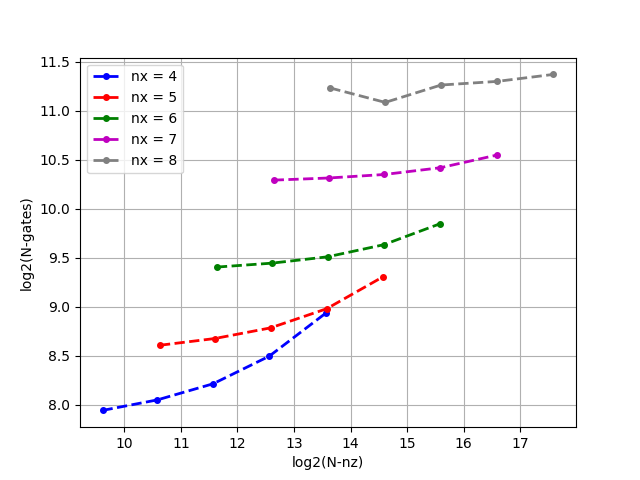

In [10]:
# -------------------------------------------------------------------------
# --- PLOT the scan: N-gates vs Nnz ---
# -------------------------------------------------------------------------

scaling_gates_nx4 = [
  # nx, nv, N_nonzero, N_gates (Rc as 1)
    [4,  4,       784,    246],
    [4,  5,      1536,    265],
    [4,  6,      3040,    297],
    [4,  7,      6048,    361],
    [4,  8,     12064,    489],
]
scaling_gates_nx5 = [    
    [5,  4,      1584,    390],
    [5,  5,      3104,    409],
    [5,  6,      6144,    441],
    [5,  7,     12224,    505],
    [5,  8,     24384,    633]
]
scaling_gates_nx6 = [
    [6,  4,      3184,    678],
    [6,  5,      6240,    697],
    [6,  6,     12352,    729],
    [6,  7,     24576,    794],
    [6,  8,     49024,    921],
]
scaling_gates_nx7 = [
    [7, 4,       6384,   1254],
    [7, 5,      12512,   1273],
    [7, 6,      24768,   1305],
    [7, 7,      49280,   1369],
    [7, 7,      98304,   1497]
]
scaling_gates_nx8 = [   
    [8, 4,      12784,   2406],
    [8, 5,      25056,   2173],
    [8, 6,      49600,   2457],
    [8, 7,      98688,   2521],
    [8, 8,     196864,   2649]
]


# --- FUNCTIONS ---
def get_data_for_one_nx(scaling_gates_nx):
    nx_chosen = scaling_gates_nx[0][0]
    
    Nnz_array = []
    N_gates_array = []
    Nv_array = []
    for one_nv in scaling_gates_nx:
        Nv_array.append(1 << one_nv[1])
        Nnz_array.append(one_nv[2])
        N_gates_array.append(one_nv[3])
    
#     return nx_chosen, Nv_array, Nnz_array, N_gates_array
    return nx_chosen, Nv_array, np.log2(Nnz_array), np.log2(N_gates_array)
# -----------------

# --- PLOT the scan ---
fig = plt.figure()
ax = fig.add_subplot(111)

nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx4)
ax.plot(log_Nnz_array, log_N_gates_array, 'b', linewidth = 2, linestyle='--',    marker='o', markersize=4, label='nx = {:d}'.format(nx_chosen))

nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx5)
ax.plot(log_Nnz_array, log_N_gates_array, 'r', linewidth = 2, linestyle='--',    marker='o', markersize=4, label='nx = {:d}'.format(nx_chosen))

nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx6)
ax.plot(log_Nnz_array, log_N_gates_array, 'g', linewidth = 2, linestyle='--',    marker='o', markersize=4, label='nx = {:d}'.format(nx_chosen))

nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx7)
ax.plot(log_Nnz_array, log_N_gates_array, 'm', linewidth = 2, linestyle='--',    marker='o', markersize=4, label='nx = {:d}'.format(nx_chosen))

nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx8)
ax.plot(log_Nnz_array, log_N_gates_array, 'gray', linewidth = 2, linestyle='--', marker='o', markersize=4, label='nx = {:d}'.format(nx_chosen))

plt.xlabel('log2(N-nz)')
plt.ylabel("log2(N-gates)")
ax.legend()
plt.grid(True)
plt.show()

del nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array

In [11]:
# -------------------------------------------------------------------------
# --- Save the scan ---
# -------------------------------------------------------------------------
mix.reload_module(mix)

nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx4)
mix.save_dat_plot_1d_file(data_.path_save_ + "/scan_N_gates_nx4.dat",    log_Nnz_array, log_N_gates_array)

nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx5)
mix.save_dat_plot_1d_file(data_.path_save_ + "/scan_N_gates_nx5.dat",    log_Nnz_array, log_N_gates_array)

nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx6)
mix.save_dat_plot_1d_file(data_.path_save_ + "/scan_N_gates_nx6.dat",    log_Nnz_array, log_N_gates_array)

nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx7)
mix.save_dat_plot_1d_file(data_.path_save_ + "/scan_N_gates_nx7.dat",    log_Nnz_array, log_N_gates_array)

nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx8)
mix.save_dat_plot_1d_file(data_.path_save_ + "/scan_N_gates_nx8.dat",    log_Nnz_array, log_N_gates_array)


del nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array

write data to a file: ../results/KIN1D1D-results/figs//scan_N_gates_nx4.dat
write data to a file: ../results/KIN1D1D-results/figs//scan_N_gates_nx5.dat
write data to a file: ../results/KIN1D1D-results/figs//scan_N_gates_nx6.dat
write data to a file: ../results/KIN1D1D-results/figs//scan_N_gates_nx7.dat
write data to a file: ../results/KIN1D1D-results/figs//scan_N_gates_nx8.dat


In [24]:
# -------------------------------------------------------------------------------------------------------------
# --- [OPTIONAL] Compare the matrix obtained from QC simulation of the oracle with the block-encoded matrix ---
# -------------------------------------------------------------------------------------------------------------
mix.reload_module(qucf_r)
mix.reload_module(ase)

dd_res = qucf_r.read_matrix_sparse(
    data_.path_qc_, data_.output_qucf_
) 
A_F_recon = dd_res["A"].get_slice(0, 0, data_.Nvar_work_)
B_fixed_recon, _ = ase.extract_fixed_profile_matrix_from_F(
    data_.nx_work_, data_.nv_work_, A_F_recon, data_.DF_work_
) 
B_fixed_recon.is_the_same_as(data_.BF_fixed_, prec = 1e-10)
del A_F_recon, B_fixed_recon

Reading the matrix from: BE_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/
date of the simulation:  01-28-2024 12:10:04
matrix name:  U_BE
N = 512
The matrices are the same


In [17]:
theta_y = 3.141310074962e+00
print("{:20.6e}".format(np.cos(theta_y/2.)))

        1.412893e-04


In [27]:
theta_y, theta_z = 3.109751982373e+00, -3.136488498004e+00
print("{:20.3e}".format(np.exp(- 1j * theta_z/2.) * np.cos(theta_y/2.)))

8.839e-02
3.591e-06+1.407e-03j
           1.407e-03


In [56]:
%tb

SystemExit: -1